# Libraries

In [ ]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
#pip install imbalanced-learn
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import shap
from sklearn.inspection import permutation_importance

# Load and join data

In [2]:
users = pd.read_csv("users.csv")
merchants = pd.read_csv("merchants.csv")
print(users.head())
print(f"The number of unique users is {len(pd.unique(users['user_id']))}") #same as the total number of rows 
print(merchants.head())
print(f"The number of unique merchants is {len(pd.unique(merchants['merchant_id']))}") #same as the total number of rows 

  user_id  age     sex    education primary_source_of_income  \
0  U00001   56   Other  High School               Employment   
1  U00002   36  Female     Bachelor                 Business   
2  U00003   70   Other  High School              Student Aid   
3  U00004   38   Other  High School                  Savings   
4  U00005   61    Male  High School               Employment   

   sum_of_monthly_installments  sum_of_monthly_expenses  country signup_date  \
0                       477.69                   243.18  Finland  2021-04-01   
1                        31.60                   737.76   France  2020-07-07   
2                       275.72                  1477.50  Finland  2022-08-23   
3                       288.29                  1135.03  Belgium  2022-05-21   
4                         7.00                   892.76    Italy  2022-03-15   

   risk_score  
0    0.571079  
1    0.705268  
2    0.429579  
3    0.581384  
4    0.420227  
The number of unique users is 20000
  

In [3]:
with open("transactions.json") as f:
    data = [json.loads(line) for line in f] #nested structure requires line-by-line load

transactions = pd.json_normalize(data) #transform JSON to tabular
print(f"The number of unique transactions is {len(pd.unique(transactions['transaction_id']))}")
transactions.head()

The number of unique transactions is 500000


,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,location.lat,location.long
0,TX000000,2022-06-17T23:28:00,U14804,M0314,130.03,in-store,EUR,Android,debit_card,1,145,0,0,40.057938,14.959737
1,TX000001,2022-01-04T15:39:00,U16634,M0675,132.00,online,EUR,Android,debit_card,1,32,1,0,42.059350,1.596625
2,TX000002,2022-09-09T21:58:00,U18005,M0479,8.65,online,EUR,Android,credit_card,1,604,1,0,50.923432,21.795262
3,TX000003,2023-11-20T06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,credit_card,0,1031,1,0,56.833396,-9.881566
4,TX000004,2022-04-28T08:08:00,U04642,M0128,101.92,in-store,EUR,Android,credit_card,1,330,0,0,54.042996,2.168516


We want to keep all transactions and add all possible data about users and merchants. Hence we use left join procedure. 

In [4]:
df_1 = pd.merge(transactions, users, on="user_id", how='left') 
print(f'First left join: the number of total rows is {len(df_1)}')
df = pd.merge(df_1, merchants, on="merchant_id", how='left', suffixes=['_user', '_merchant']) #use suffixes to distinguish country columns
print(f'Second left join: the number of total rows is {len(df)}')

First left join: the number of total rows is 500000
Second left join: the number of total rows is 500000


# EDA

Exploratory Data Analysis includes:
- Missing values
- Variable transformation (Time-Based analysis included)
- Visualized feature distribution (fraud vs non-fraud)
- Outlier detection
- Correlation analysis
- Class imbalance

In [5]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,country_user,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,TX000000,2022-06-17T23:28:00,U14804,M0314,130.03,in-store,EUR,Android,debit_card,1,...,Sweden,2022-08-10,0.426675,travel,France,0.581711,3,74.97,23,1
1,TX000001,2022-01-04T15:39:00,U16634,M0675,132.00,online,EUR,Android,debit_card,1,...,France,2024-05-22,0.729627,electronics,Germany,0.568933,2,56.92,23,0
2,TX000002,2022-09-09T21:58:00,U18005,M0479,8.65,online,EUR,Android,credit_card,1,...,Italy,2021-05-18,0.393848,gaming,Denmark,0.608070,5,98.93,75,0
3,TX000003,2023-11-20T06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,credit_card,0,...,Portugal,2021-09-05,0.393405,electronics,Portugal,0.592656,4,21.60,82,0
4,TX000004,2022-04-28T08:08:00,U04642,M0128,101.92,in-store,EUR,Android,credit_card,1,...,Austria,2023-06-01,0.524168,gaming,Spain,0.450223,4,60.61,82,0


In [6]:
df.isna().sum()

transaction_id                        0
timestamp                             0
user_id                               0
merchant_id                           0
amount                                0
channel                               0
currency                              0
device                                0
payment_method                        0
is_international                      0
session_length_seconds                0
is_first_time_merchant                0
is_fraud                              0
location.lat                          0
location.long                         0
age                                   0
sex                                   0
education                         96566
primary_source_of_income              0
sum_of_monthly_installments           0
sum_of_monthly_expenses               0
country_user                          0
signup_date                           0
risk_score                            0
category                              0


In [7]:
df[pd.isna(df['education'])]

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,country_user,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
5,TX000005,2023-07-22T08:39:00,U01335,M0272,83.21,mobile,EUR,Android,debit_card,1,...,Poland,2020-09-09,0.533121,education,Finland,0.662969,5,166.18,80,1
17,TX000017,2022-01-07T16:31:00,U16459,M0724,122.11,mobile,EUR,Android,debit_card,1,...,Austria,2021-02-10,0.694816,restaurants,France,0.284208,1,45.75,9,1
19,TX000019,2022-01-27T23:40:00,U02026,M0618,178.94,in-store,EUR,Android,credit_card,1,...,Germany,2024-10-09,0.621181,grocery,Ireland,0.825521,1,59.41,19,0
25,TX000025,2023-05-31T11:00:00,U03144,M0962,112.38,mobile,EUR,Web,debit_card,1,...,France,2023-11-05,0.469093,restaurants,Poland,0.607160,6,90.67,52,0
27,TX000027,2022-05-05T20:25:00,U13107,M0443,38.21,in-store,EUR,Web,debit_card,0,...,Ireland,2024-06-26,0.542685,clothing,Ireland,1.000000,2,28.56,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499982,TX499982,2022-06-27T06:24:00,U17105,M0705,124.89,online,EUR,iOS,debit_card,1,...,Ireland,2022-01-30,0.416165,clothing,Poland,1.000000,5,134.49,44,1
499986,TX499986,2022-04-24T00:53:00,U08749,M0232,17.86,online,EUR,iOS,mobile_payment,0,...,France,2022-04-17,0.598752,restaurants,France,0.456625,5,137.87,38,1
499988,TX499988,2023-01-12T21:14:00,U16974,M0243,107.19,online,EUR,Android,mobile_payment,1,...,Sweden,2024-08-27,0.556321,education,Spain,0.972907,1,230.92,21,1
499989,TX499989,2022-10-13T09:15:00,U01512,M0062,59.98,online,EUR,iOS,bank_transfer,1,...,Italy,2021-03-01,0.363156,grocery,Finland,0.796693,3,16.91,103,0


Pandas treats None as a missing value. Refering this article: https://note.nkmk.me/en/python-pandas-nan-none-na/#:~:text=None%20is%20also%20considered%20a%20missing%20value,-In%20pandas%2C%20None&text=Since%20nan%20is%20a%20floating,other%20values%20are%20integers%20int%20.&text=Although%20None%20in%20the%20object,missing%20value%20by%20isnull()%20.
We assume that in the user data context, None means a separate category - lack of education in general. 

In [8]:
df['education'] = df['education'].fillna('No education')

In [9]:
df.columns

Index(['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount',
       'channel', 'currency', 'device', 'payment_method', 'is_international',
       'session_length_seconds', 'is_first_time_merchant', 'is_fraud',
       'location.lat', 'location.long', 'age', 'sex', 'education',
       'primary_source_of_income', 'sum_of_monthly_installments',
       'sum_of_monthly_expenses', 'country_user', 'signup_date', 'risk_score',
       'category', 'country_merchant', 'trust_score',
       'number_of_alerts_last_6_months', 'avg_transaction_amount',
       'account_age_months', 'has_fraud_history'],
      dtype='object')

In [10]:
df['currency'].value_counts()

currency
EUR    500000
Name: count, dtype: int64

Variables processing:
- Delete the keys useless for modelling: **transaction_id**, **merchant_id** (there is a specific column has_fraud_history), **currency** (all transactions in the training dataset are in EUR)

- May be transformed: **timestamp** (day period - morning, day, evening, night), **user_id** (a flag to link to a fraud history - similar to merchant), **signup_date** (months of cooperation started from today), **location.lat/long** (transaction country to compare with the user and merchant one - if similar then 1)

- Ready for the further EDA: **amount**, **is_international**, **session_length_seconds**, **is_first_time_merchant**, **age**, **sum_of_monthly_installments**, **sum_of_monthly_expenses**, **risk_score**, **trust_score**, **number_of_alerts_last_6_months**, **avg_transaction_amount**, **account_age_months**, **has_fraud_history**

- Requires One-Hot or Label Encoding: **channel**, **device**, **payment_method**, **sex**, **primary_source_of_income**, **category**, **country_user** (too many categories), **country_merchant** (too many categories)

- Requires Ordinal Encoding: **education**

- Target: **is_fraud**  

### Variable transformation 

In [11]:
df = df.drop(['transaction_id', 'merchant_id', 'currency'], axis=1)

First, we conduct time-based analysis to decide whether a year, month, day, hour period impacts the fraud frequency. We aim to answer the question - are there any seasonality patterns? Time dimensions include month, weekday, hour.

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
def plot_fraud_by_time(df, time_unit='hour'):
    '''
    Plots fraud count by time unit: 'hour', 'weekday', 'month', 'year'.
    '''
    #Extract time features
    if time_unit == 'hour':
        df['time_feature'] = df['timestamp'].dt.hour
        categories = list(range(24))
    elif time_unit == 'weekday':
        df['time_feature'] = df['timestamp'].dt.day_name()
        categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    elif time_unit == 'month':
        df['time_feature'] = df['timestamp'].dt.month_name()
        categories = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']
    elif time_unit == 'year':
        df['time_feature'] = df['timestamp'].dt.year
        categories = sorted(df['time_feature'].unique())
    else:
        df['time_feature'] = df[time_unit]

    counts = df.groupby(['time_feature', 'is_fraud']).size().unstack(fill_value=0)
    
    if 'categories' in locals():
        counts = counts.reindex(categories) #only if available

    #plot
    ax = counts.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Fraud vs Non-Fraud Count by {time_unit.capitalize()}')
    plt.xlabel(time_unit.capitalize())
    plt.ylabel('Transaction Count')
    plt.legend(['Non-Fraud', 'Fraud'], title='Transaction Type')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()

    for idx in range(len(counts)): #annotate with fraud %
        total = counts.iloc[idx].sum()
        fraud_count = counts.iloc[idx][1]
        if fraud_count > 0 and total > 0:
            fraud_pct = 100 * fraud_count / total
            ax.text(idx + 0.2, fraud_count + max(counts[1]) * 0.01, f'{fraud_pct:.1f}%', ha='center', va='bottom', fontsize=9, rotation=90)

    plt.show()

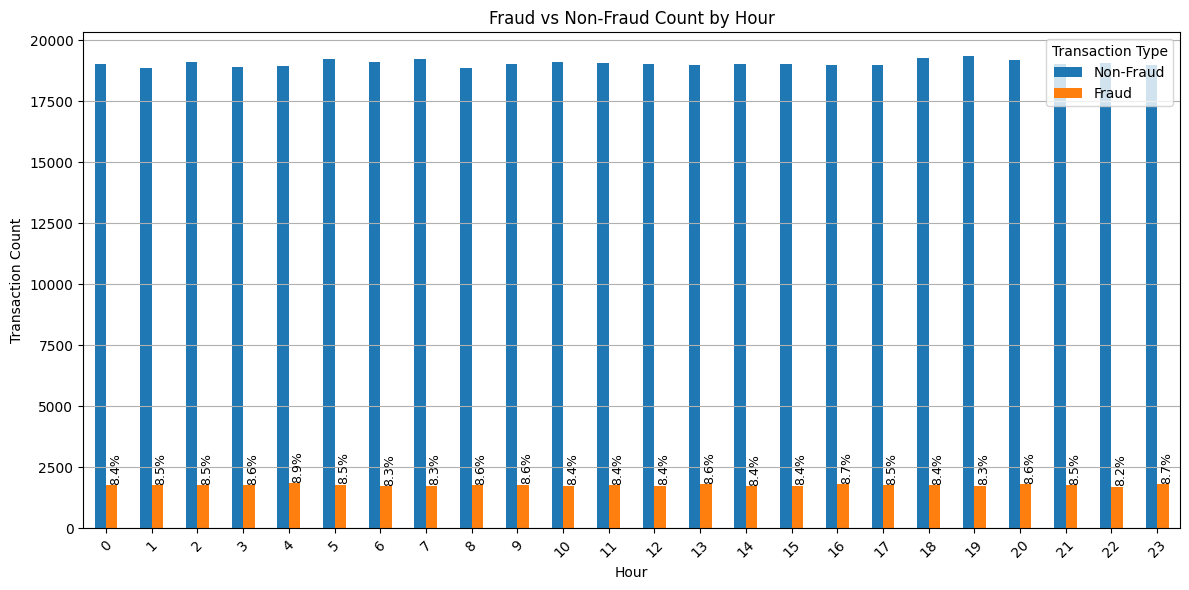

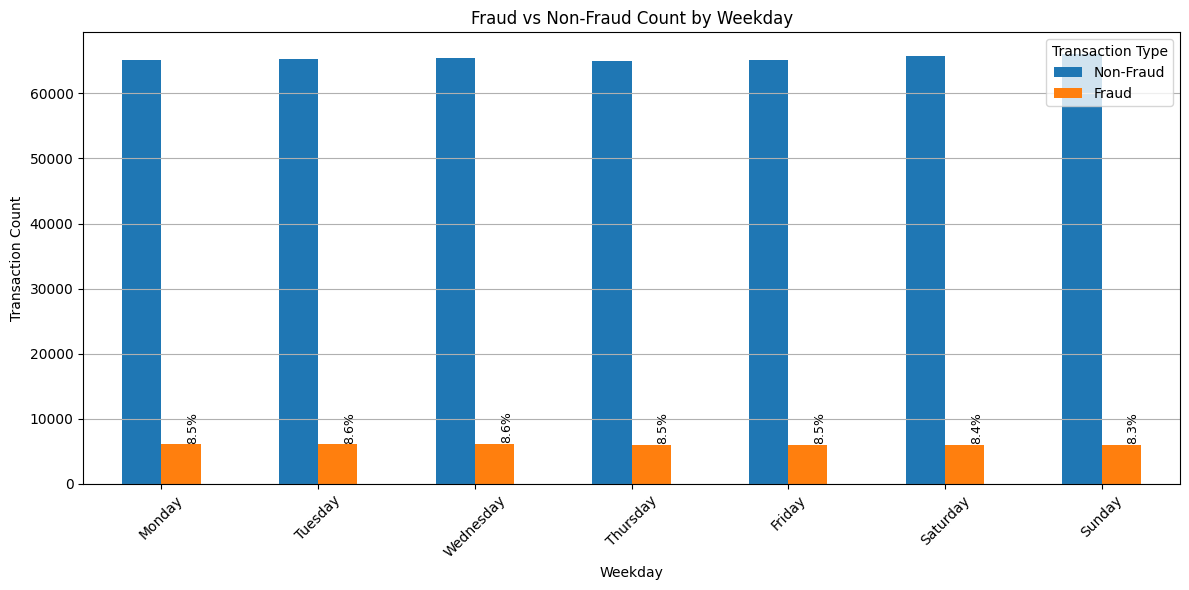

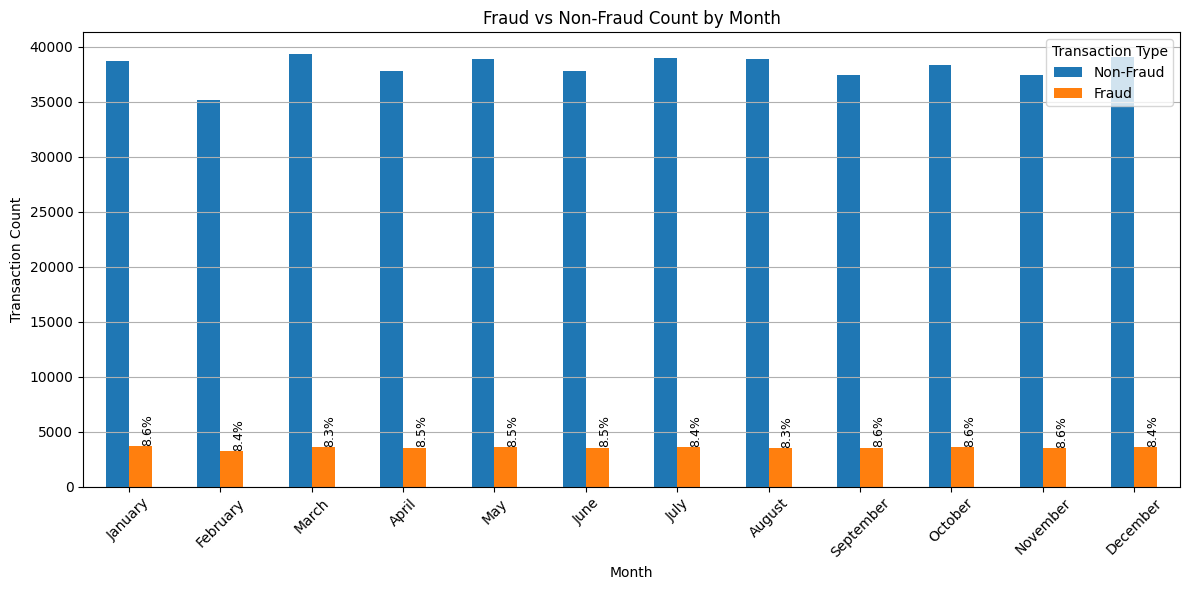

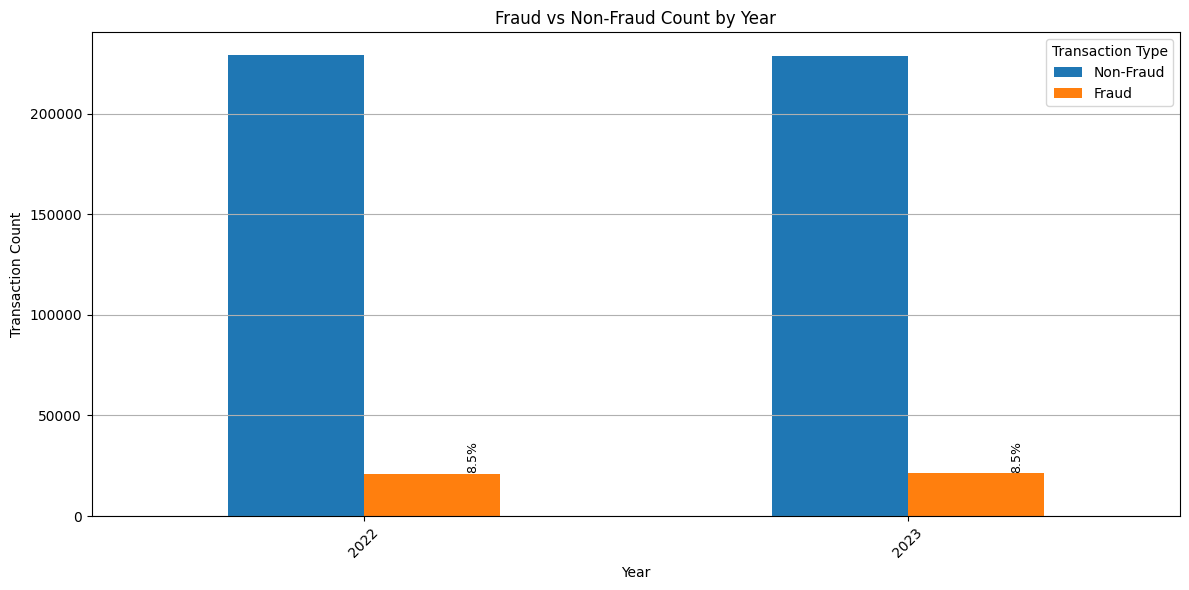

In [14]:
plot_fraud_by_time(df, time_unit='hour')
plot_fraud_by_time(df, time_unit='weekday')
plot_fraud_by_time(df, time_unit='month')
plot_fraud_by_time(df, time_unit='year')

We do not identify certain patterns. At 4 a.m. the total number of frauds is higher but it may be a coincidence (noise in statistical terms). As a next step, we want to generalize the hour time dimension to the time of a day. 

In [15]:
def map_time_of_day(hour):
    '''Map hour to part of day'''
    if 6 <= hour < 11:
        return 'morning'
    elif 11 <= hour < 17:
        return 'day'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

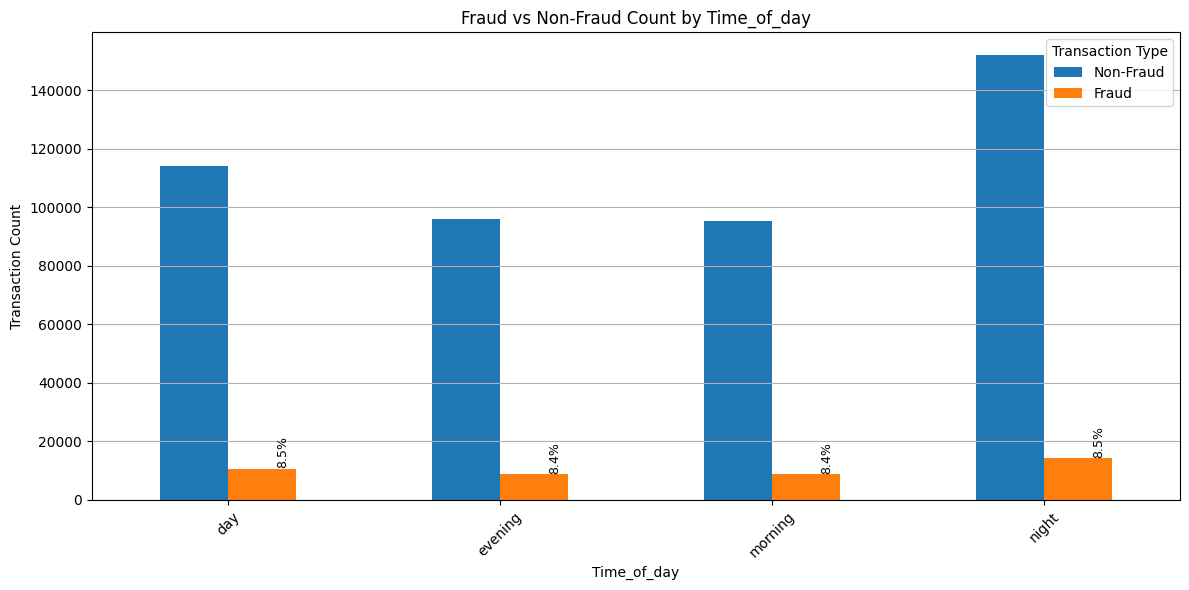

In [16]:
df['hour'] = df['timestamp'].dt.hour
df['time_of_day'] = df['hour'].apply(map_time_of_day)
plot_fraud_by_time(df, time_unit='time_of_day')

We conclude that a certain time of the transaction is not associated with higher risk of fraud. Since fraud shares are relatively the same across periods in the same time dimension we do not take into account time of the transaction. We could simulate real-world prediction by splitting train-test by timestamp - i.e. train on the past, test on the future. However the fraud rate is stable over time and time-based train-test split is not justified.

In [17]:
df.drop(columns=['hour', 'weekday', 'month', 'time_feature', 'time_of_day'], errors='ignore', inplace=True) #delete technical columns

Next, we assume that we have all possible transactions. This way we have a full history of transactions and are able to link user to frauds. Similar to merchant, we can create a flag that takes 1 if a user at least one prior fraud, otherwise - 0. We do not have methodology for the risk score of a user, therefore we assume that user-level fraud history indicator is not correlated with risk score, however we will still test it further. We also want to avoid data leakage, so we look only at earlier transactions by that user while computing flag. 

In [18]:
df = df.sort_values(by=['user_id', 'timestamp']) #sort to have chronological order
df['has_fraud_history_user'] = ( #cumulative max of fraud for each user up to before the current row
    df.groupby('user_id')['is_fraud'].transform(lambda x: x.shift().fillna(0).cumsum().gt(0).astype(int))
)
df['has_fraud_history_user'] = df['has_fraud_history_user'].fillna(0).astype(int) #handle the first transaction of user
df['has_fraud_history_user'].value_counts()

has_fraud_history_user
1    291467
0    208533
Name: count, dtype: int64

In [19]:
df.rename(columns={'has_fraud_history': 'has_fraud_history_merchant'}, inplace=True)
df['has_fraud_history_merchant'].value_counts()

has_fraud_history_merchant
1    260412
0    239588
Name: count, dtype: int64

Similar to merchant, we create account age in months for an user based on the signup date. 

In [20]:
def calculate_months_diff(start_date, end_date):
    '''number of months difference'''
    return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

In [21]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
today = pd.Timestamp.today() #the date of the modelling
df['account_age_months_user'] = df['signup_date'].apply(lambda x: calculate_months_diff(x, today))
df.rename(columns={'account_age_months': 'account_age_months_merchant'}, inplace=True)

In [22]:
df = df.drop(['signup_date'], axis=1) #not needed anymore

Initial attempt to link the geographical coordinates to a specific country is not successful because the number of unique coordinates is too large. Geographical API was used for that, however it has limited request capacity. Therefore, we decide to exclude latitude and longitude from the variable set. 

In [23]:
df = df.drop(['location.lat', 'location.long'], axis=1) 

The transaction_to_spending_ratio variable represents how large a transaction is compared to a user's total monthly financial capacity (income estimated by monthly installments + expenses).

We create this variable to help fraud detection algorithms identify unusual spending behavior—for example, a very high ratio might indicate a suspicious transaction that doesn’t align with a user’s typical financial activity, potentially signaling fraud.

In [24]:
df['transaction_to_spending_ratio'] = df['amount']/(df["sum_of_monthly_installments"]+df["sum_of_monthly_expenses"])

In [25]:
df.columns

Index(['timestamp', 'user_id', 'amount', 'channel', 'device', 'payment_method',
       'is_international', 'session_length_seconds', 'is_first_time_merchant',
       'is_fraud', 'age', 'sex', 'education', 'primary_source_of_income',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses',
       'country_user', 'risk_score', 'category', 'country_merchant',
       'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months_merchant',
       'has_fraud_history_merchant', 'has_fraud_history_user',
       'account_age_months_user', 'transaction_to_spending_ratio'],
      dtype='object')

### Data visualtion

Before the proceed with further manipulation of the dataset, let's explore our data

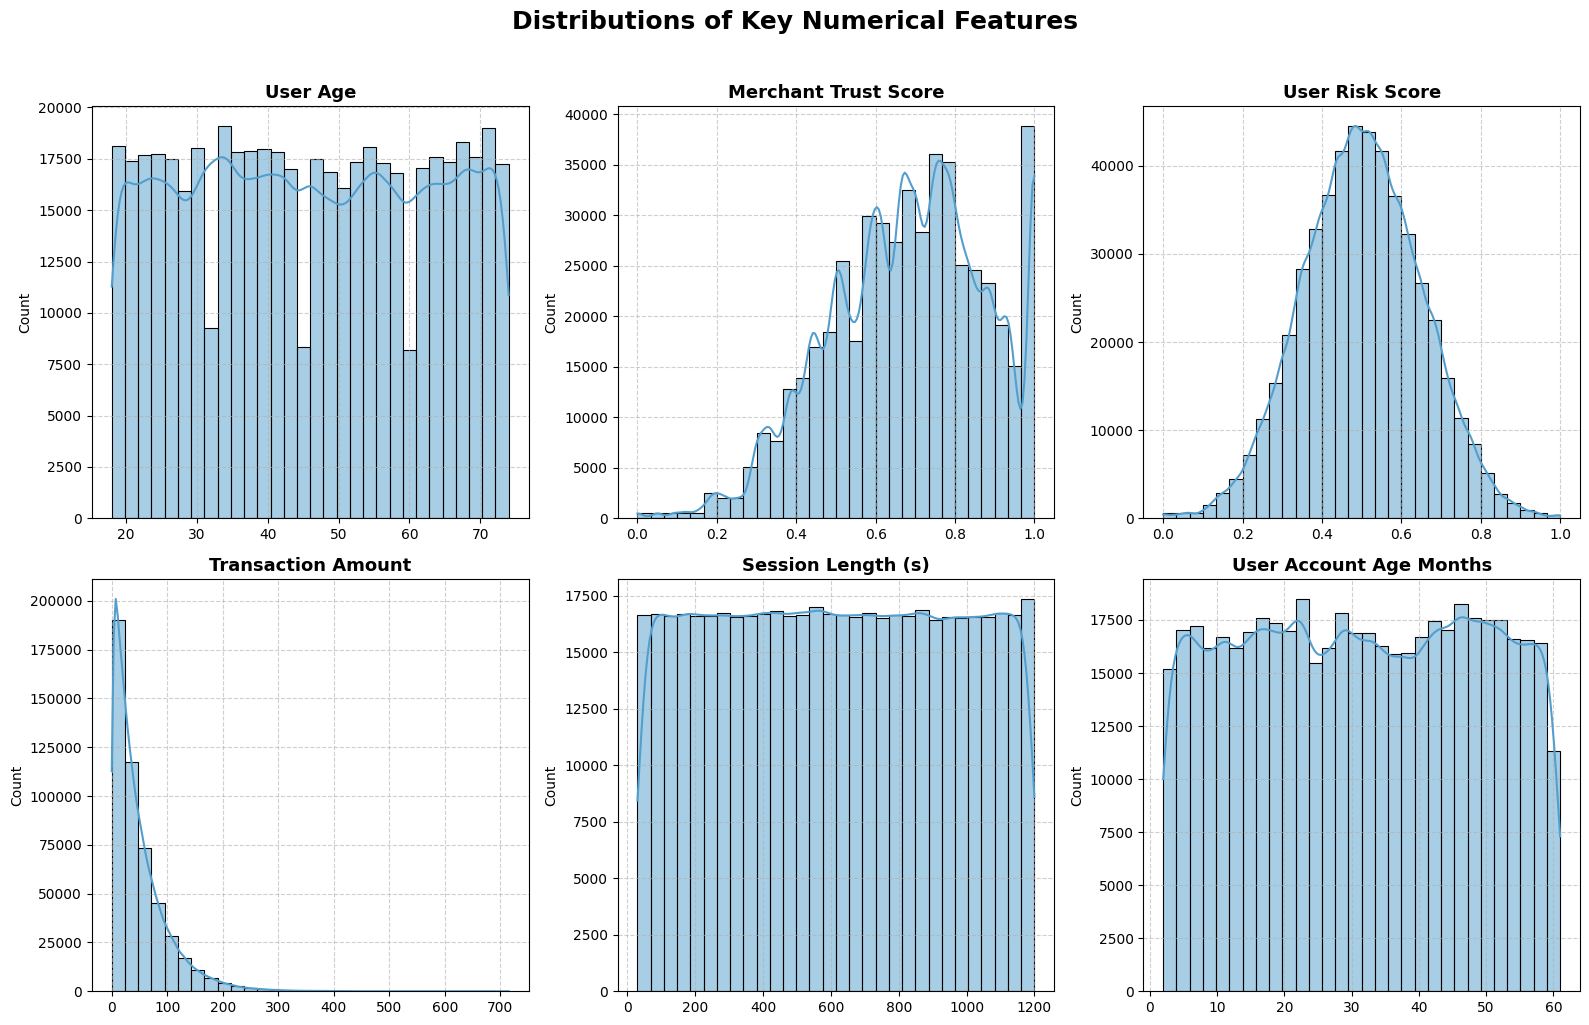

In [26]:
# We select some continuous which we would like to explore
features = ['age', 'trust_score', 'risk_score', 'amount', 'session_length_seconds', 'account_age_months_user']
titles = ['User Age', 'Merchant Trust Score', 'User Risk Score', 'Transaction Amount', 'Session Length (s)', 'User Account Age Months']

plt.figure(figsize=(16, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, color=sns.color_palette("Blues")[3])
    plt.title(titles[i], fontsize=13, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Count')
    plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Distributions of Key Numerical Features', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Visualized feature distribution (fraud vs non-fraud)

Based on the plotted distributions, we can draw several observations about the dataset:

- **User Age**, **Session Length**, and **User Account Age (Months)** appear to be fairly evenly distributed, without strong skewness or extreme clustering.
- The **User Risk Score** closely follows a normal distribution, looks like a well-balanced scoring system.
- The **Merchant Trust Score** is heavily concentrated at a score of **1**, suggesting that the majority of merchants are rated at the highest trust level.
- Most **Transaction Amounts** fall within the **$0 to $25** range, indicating a large volume of low-value transactions.


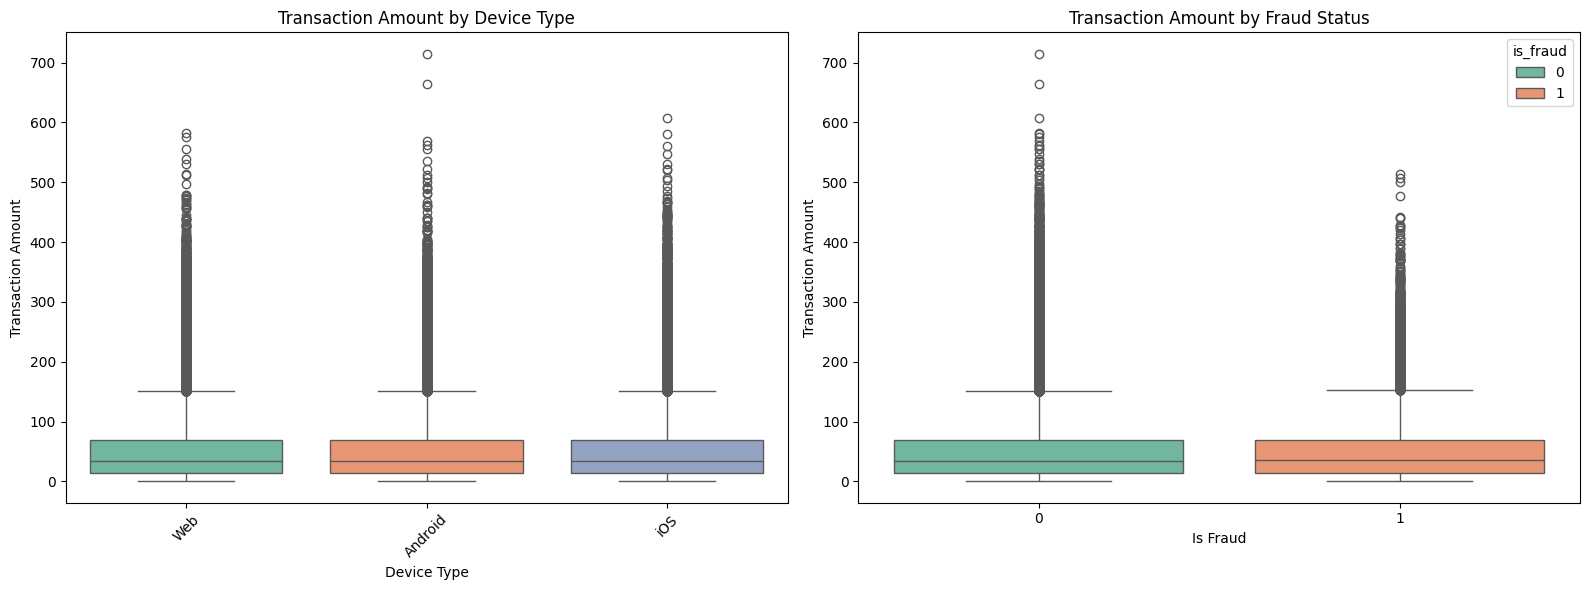

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Amount by Device
sns.boxplot(data=df, x='device', y='amount', hue='device', palette='Set2', ax=axes[0])
axes[0].set_title("Transaction Amount by Device Type")
axes[0].set_xlabel("Device Type")
axes[0].set_ylabel("Transaction Amount")
axes[0].tick_params(axis='x', rotation=45)

# Right plot: Amount by Fraud Status
sns.boxplot(data=df, x='is_fraud', y='amount', hue='is_fraud', palette='Set2', ax=axes[1])
axes[1].set_title("Transaction Amount by Fraud Status")
axes[1].set_xlabel("Is Fraud")
axes[1].set_ylabel("Transaction Amount")

plt.tight_layout()
plt.show()

We also created two boxplots to better understand the distribution of transaction amounts. (Boxplots are great for spotting outliers and comparing medians, ranges, and overall spread across categories.)

In the left plot, we examined transaction amounts by device type. The distribution appears fairly normal across all device types, with just a slight tendency for Android users to make higher purchases—still, nothing suspicious.

In the right plot, we compared transaction amounts by fraud status. Interestingly, non-fraudulent transactions tend to involve higher amounts than fraudulent ones, which might reflect fraudsters trying to avoid detection by keeping amounts low.

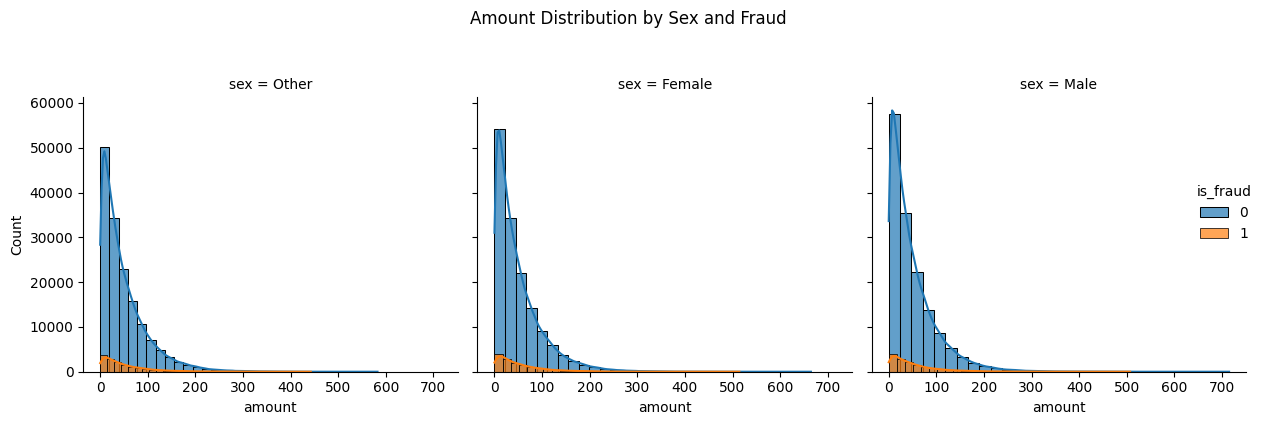

In [28]:
g = sns.FacetGrid(df, col="sex", hue="is_fraud", height=4, col_wrap=3)
g.map(sns.histplot, "amount", bins=30, kde=True, alpha=0.7).add_legend()
g.fig.suptitle("Amount Distribution by Sex and Fraud", y=1.05)

plt.tight_layout()
plt.show()

Another plot we analyzed shows the distribution of transaction amounts by sex and age. Unfortunately, we didn’t observe any unusual patterns—the data visualization looks fairly consistent across all categories: Other, Female, and Male.
The only slight observation is that Males appear to spend slightly less on purchases when the transaction is not marked as fraudulent

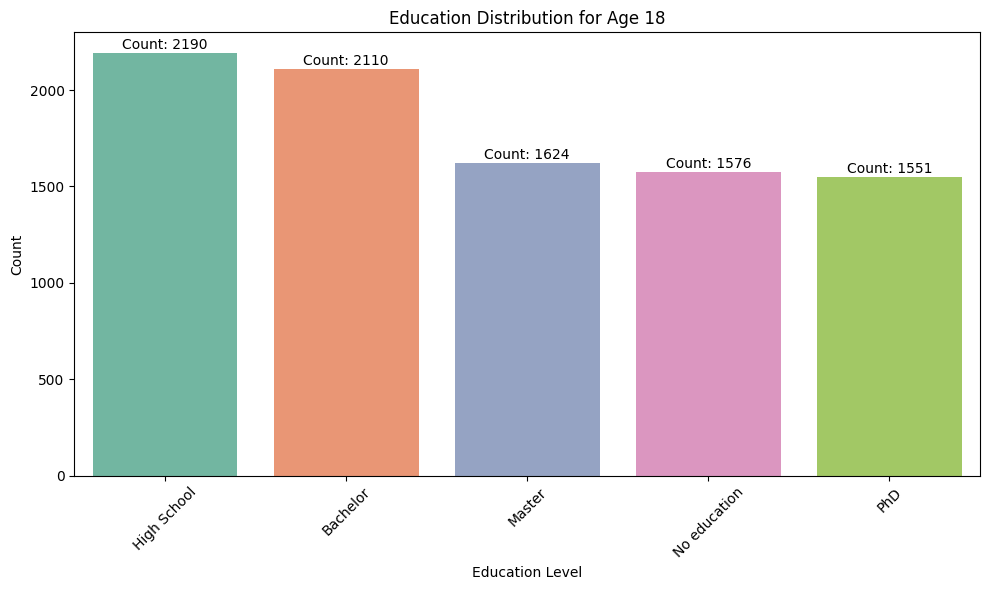

In [29]:
age_18_data = df[df["age"] == 18]
education_counts = age_18_data["education"].value_counts()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=education_counts.index, y=education_counts.values, hue=education_counts.index, palette="Set2")

for i, (category, count) in enumerate(education_counts.items()):
    ax.text(i, count + 5, f"Count: {count}", ha='center', va='bottom', fontsize=10)

plt.title("Education Distribution for Age 18")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We had a few concerns about the logical consistency of the dataset-although we know it is synthetic... Still, we wanted to explore the distribution of education levels among users who are 18 years old. The most common category is High School, with 2,190 users, which seems perfectly reasonable.

But then… we noticed something impressive—1,551 users at age 18 already hold a PhD. Either we’ve stumbled upon the most overachieving teenagers in history, or this dataset might be flexing a little too hard on realism.

### Outlier detection

In [30]:
def detect_outliers_iqr(data):
    '''outliers fall outside 1.5 * IQR above the third quartile or below the first'''
    outlier_flags = pd.DataFrame(index=data.index)
    for col in data.select_dtypes(include='number').columns: #only numerical
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_flags[col + '_outlier'] = (data[col] < lower_bound) | (data[col] > upper_bound) #new column detecting outliers
    return outlier_flags

In [ ]:
outliers = detect_outliers_iqr(df)
df_with_outliers = pd.concat([df, outliers], axis=1)

In [32]:
outlier_mask = df_with_outliers.filter(like='_outlier').any(axis=1) #keep only rows where any of the _outlier columns is True
df_with_any_outlier = df_with_outliers[outlier_mask]
df_with_any_outlier

,timestamp,user_id,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,...,sum_of_monthly_expenses_outlier,risk_score_outlier,trust_score_outlier,number_of_alerts_last_6_months_outlier,avg_transaction_amount_outlier,account_age_months_merchant_outlier,has_fraud_history_merchant_outlier,has_fraud_history_user_outlier,account_age_months_user_outlier,transaction_to_spending_ratio_outlier
95555,2022-08-09 12:30:00,U00001,22.94,online,iOS,credit_card,1,426,0,1,...,False,False,False,False,False,False,False,False,False,False
381637,2022-12-10 09:06:00,U00001,12.95,mobile,Web,credit_card,1,742,1,1,...,False,False,False,False,False,False,False,False,False,False
157928,2023-06-01 06:41:00,U00001,18.40,in-store,Android,bank_transfer,1,186,0,1,...,False,False,False,False,False,False,False,False,False,False
67571,2023-06-15 02:47:00,U00001,21.81,mobile,iOS,mobile_payment,1,842,1,0,...,False,False,False,False,True,False,False,False,False,False
430619,2022-06-02 15:38:00,U00002,141.85,in-store,Web,credit_card,1,991,1,0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88228,2023-03-22 15:14:00,U20000,144.52,in-store,iOS,credit_card,1,519,1,0,...,False,False,False,False,False,False,False,False,False,True
123990,2023-06-26 10:32:00,U20000,78.85,mobile,Android,mobile_payment,1,1109,0,0,...,False,False,False,False,False,False,False,False,False,True
487026,2023-06-26 22:18:00,U20000,60.15,online,iOS,bank_transfer,1,129,1,0,...,False,False,False,False,False,False,False,False,False,True
251399,2023-11-11 18:24:00,U20000,134.76,in-store,Android,mobile_payment,1,504,1,0,...,False,False,False,False,False,False,False,False,False,True


In [33]:
df_with_outliers.filter(like='_outlier').sum()

amount_outlier                            24250
is_international_outlier                  35669
session_length_seconds_outlier                0
is_first_time_merchant_outlier                0
is_fraud_outlier                          42411
age_outlier                                   0
sum_of_monthly_installments_outlier       23406
sum_of_monthly_expenses_outlier           22816
risk_score_outlier                         2841
trust_score_outlier                        2062
number_of_alerts_last_6_months_outlier     5900
avg_transaction_amount_outlier            17431
account_age_months_merchant_outlier           0
has_fraud_history_merchant_outlier            0
has_fraud_history_user_outlier                0
account_age_months_user_outlier               0
transaction_to_spending_ratio_outlier     49308
dtype: int64

We have decided not to delete outliers due to their potencial impact to detect fraud transactions.

### Correlation analysis

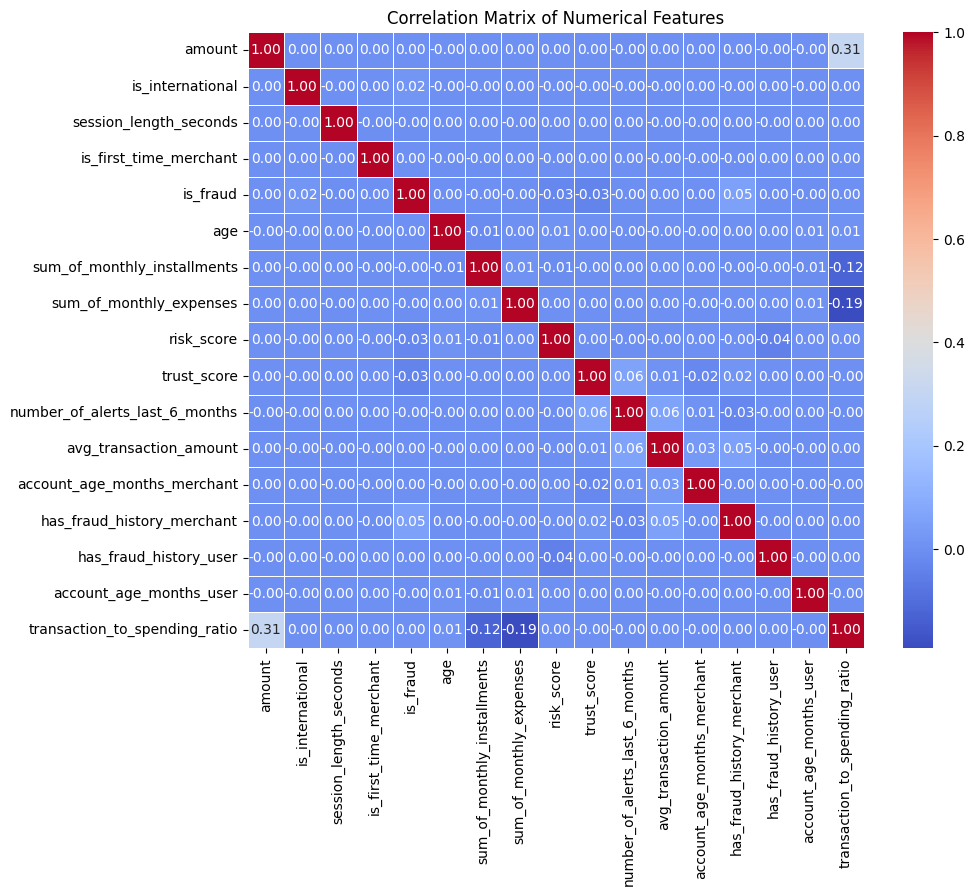

In [34]:
df_numeric = df.select_dtypes(include='number') #numeric features
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

No high correlation between regressors is observed. Expected correlation between **trust_score** and **has_fraud_history_merchant** / **risk_score** and **has_fraud_history_user** is not proved empirically. Features are not correlated with the target either. 

Final variable set presents as follows - timestamp and user_id may still be used in train-test split.

In [35]:
target_col = 'is_fraud'  #move target to the end
cols = [col for col in df.columns if col != target_col] + [target_col]
df = df[cols]

In [36]:
df.columns

Index(['timestamp', 'user_id', 'amount', 'channel', 'device', 'payment_method',
       'is_international', 'session_length_seconds', 'is_first_time_merchant',
       'age', 'sex', 'education', 'primary_source_of_income',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses',
       'country_user', 'risk_score', 'category', 'country_merchant',
       'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months_merchant',
       'has_fraud_history_merchant', 'has_fraud_history_user',
       'account_age_months_user', 'transaction_to_spending_ratio', 'is_fraud'],
      dtype='object')

### Class imbalance

In [37]:
df['is_fraud'].value_counts()

is_fraud
0    457589
1     42411
Name: count, dtype: int64

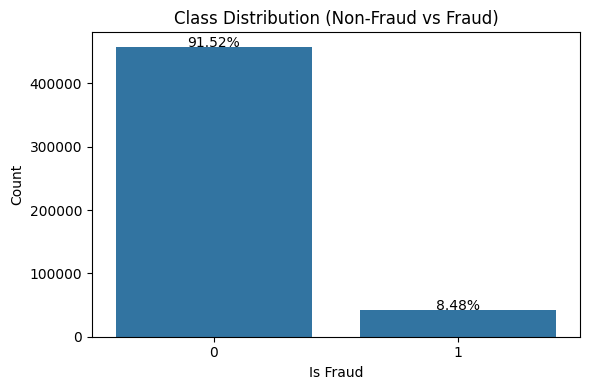

In [38]:
class_counts = df['is_fraud'].value_counts(normalize=True) * 100  #percentages instead of raw counts
labels = class_counts.index.tolist()
values = class_counts.values

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='is_fraud', data=df)

for i, v in enumerate(values):
    plt.text(i, v * len(df) / 100 + 100, f"{v:.2f}%", ha='center')

plt.title('Class Distribution (Non-Fraud vs Fraud)')
plt.xlabel('Is Fraud')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Class imbalance is clearly seen in the data. Models trained on such data tend to ignore the minority class (frauds) by predicting "non-fraud" all the time. To address this problem we use SMOTE technique (a kind of oversampling) that balance the dataset by creating synthetic examples of the frauds. It improves recall and is better than random oversampling - instead of duplicating, it generates new rows. SMOTE technique has drawbacks as it can introduce noisy or unrealistic samples, however we are safe while dealing with already synthetic data. 

# Train-test split with user grouping and SMOTE

SMOTE should only be applied to the training part of the data, hence we need to split the data first. According to the time-based analysis fraud rate does not change over time (year, month), that is why time-based split by timestamp is not used. Instead, we implement a Group Shuffle Split by user to avoid user leakage (the same user does not appear in both train and test). We have large dataset, therefore standard 80-20% ratio is accepted.

In [39]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #seed is used for replicability
for train_idx, test_idx in gss.split(df, groups=df['user_id']):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

In [40]:
train = train.drop(['timestamp', 'user_id'], axis=1) #not needed anymore
test = test.drop(['timestamp', 'user_id'], axis=1) #not needed anymore

In [41]:
print(train.shape)
print(test.shape)

(399797, 26)
(100203, 26)


In [42]:
train.head(10)

,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,education,...,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months_merchant,has_fraud_history_merchant,has_fraud_history_user,account_age_months_user,transaction_to_spending_ratio,is_fraud
33684,52.08,online,iOS,debit_card,1,237,1,36,Female,Bachelor,...,Ireland,0.321765,1,49.11,31,1,0,58,0.067693,0
308730,19.22,mobile,Web,mobile_payment,1,262,0,36,Female,Bachelor,...,Finland,0.986760,2,11.01,95,1,0,58,0.024982,0
231144,12.31,in-store,iOS,credit_card,1,908,1,36,Female,Bachelor,...,Finland,1.000000,3,41.86,65,0,0,58,0.016000,0
197693,49.03,in-store,Web,bank_transfer,1,733,1,36,Female,Bachelor,...,Spain,0.817256,2,59.84,17,0,0,58,0.063728,0
412248,14.21,in-store,Android,mobile_payment,1,858,0,36,Female,Bachelor,...,Ireland,0.639068,1,50.52,116,1,0,58,0.018470,0
299567,25.36,mobile,Android,mobile_payment,1,139,0,36,Female,Bachelor,...,Belgium,0.693614,4,211.65,48,1,0,58,0.032962,0
81088,21.09,mobile,iOS,mobile_payment,1,707,1,36,Female,Bachelor,...,Denmark,1.000000,1,5.23,44,0,0,58,0.027412,0
430619,141.85,in-store,Web,credit_card,1,991,1,36,Female,Bachelor,...,Poland,0.467349,2,89.82,116,0,0,58,0.184374,0
229609,7.86,mobile,iOS,debit_card,1,46,0,36,Female,Bachelor,...,Italy,0.870627,3,33.33,28,0,0,58,0.010216,1
69383,32.84,in-store,Web,debit_card,1,1167,1,36,Female,Bachelor,...,Belgium,0.607229,1,16.77,9,1,1,58,0.042685,0


In [43]:
X_train = train.drop(columns=['is_fraud']) 
y_train = train['is_fraud']
X_test = test.drop(columns=['is_fraud'])
y_test = test['is_fraud']

SMOTE technique handles only numerical features, therefore categorical features need to be encoded. One-Hot encoding is not a good choice because we do not want to have unrealistic combinations in the generated rows (e.g. both category_gaming and category_clothing is 1 whereas in reality only one category can be valid). 

### Variable encoding

After visualization we can encode the categorical variables. Most ML models require numeric input - Logistic Regression, SVM, Neural Networks (MLPs) among others. Tree-based models - like CatBoost and latest versions of XGBoost - can directly ingest categorical features without preprocessing but in order to balance classes we need numeric input.

We implement 3 approaches for the encoding:
- Most categorical columns are label-encoded, that assumes ordinal meaning (i.e. 0<1<2), even if it is not true. Since we intend to mostly use tree-based models that handle categorical features it is not a big problem but for the application of linear SVM or MLPs another approach should be used. 
- Education levels have meaningful order, therefore they are encoded with integers reflecting it
- User and merchant countries have many unique categories, therefore can only be used in tree-based methods that handle them without assuming linear relationships. 

Education has ordinal meaning that is why it is encoded separately.

In [44]:
df['education'].value_counts()

education
PhD             103760
Master          100526
Bachelor        100325
High School      98823
No education     96566
Name: count, dtype: int64

In [45]:
# If the value 'None' in the education column is not displayed as a missing value (NA), 
# the following code corrects it by replacing such entries with 'No education' (for Bogdan):
df['education'] = df['education'].apply(lambda x: 'No education' if 'None' in x else x)

In [46]:
education_order = ['No education', 'High School', 'Bachelor', 'Master', 'PhD']
X_train['education'] = pd.Categorical(X_train['education'], categories=education_order, ordered=True).codes
X_test['education'] = pd.Categorical(X_test['education'], categories=education_order, ordered=True).codes

In [47]:
categorical_cols = ['channel', 'device', 'payment_method', 'sex', 'primary_source_of_income', 'category', 'country_merchant', 'country_user']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  #same encoder for test
    label_encoders[col] = le

all_cat_cols = categorical_cols + ['education']
cat_indices = [X_train.columns.get_loc(col) for col in all_cat_cols]

smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42) #instance with random seed
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

#sanity check
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_resampled.value_counts())

Before SMOTE:
 is_fraud
0    365819
1     33978
Name: count, dtype: int64
After SMOTE:
 is_fraud
0    365819
1    365819
Name: count, dtype: int64


For models like Logistic Regression, SVM, MLPs we need to change the approach, since we do not want to mislead linear models to assume a numeric relationship (e.g. in-store as 0 is lower than online as 1) by using LabelEncoder. Therefore we use one-hot encoding and simple oversampling that duplicates the rows instead of generation. Countries of users and merchants are omitted.

In [48]:
one_hot_cols = ['channel', 'device', 'payment_method', 'sex', 'primary_source_of_income', 'category']
df_one_hot = pd.get_dummies(df, columns=one_hot_cols, drop_first=True, dtype=int) #avoid multicollinearity

In [49]:
df_one_hot['education'] = pd.Categorical(df_one_hot['education'], categories=education_order, ordered=True).codes #same Ordinal encoding
df_one_hot = df_one_hot.drop(['timestamp', 'user_id', 'country_user', 'country_merchant'], axis=1) #not needed anymore
cols = [col for col in df_one_hot.columns if col != target_col] + [target_col]
df_one_hot = df_one_hot[cols]
df_one_hot.columns

Index(['amount', 'is_international', 'session_length_seconds',
       'is_first_time_merchant', 'age', 'education',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'risk_score',
       'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months_merchant',
       'has_fraud_history_merchant', 'has_fraud_history_user',
       'account_age_months_user', 'transaction_to_spending_ratio',
       'channel_mobile', 'channel_online', 'device_Web', 'device_iOS',
       'payment_method_credit_card', 'payment_method_debit_card',
       'payment_method_mobile_payment', 'sex_Male', 'sex_Other',
       'primary_source_of_income_Employment',
       'primary_source_of_income_Retirement',
       'primary_source_of_income_Savings',
       'primary_source_of_income_Student Aid',
       'primary_source_of_income_Unemployment', 'category_education',
       'category_electronics', 'category_gaming', 'category_grocery',
       'category_restaurants', 

We do not want to lose a lot of non-fraud data with undersampling approach, therefore basic oversampling is used - fraud rows are duplicated to balance the classes.

In [50]:
X_lin = df_one_hot.drop(columns=['is_fraud'])
y_lin = df_one_hot['is_fraud']
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42, stratify=y_lin) #preserve fraud ratio

In [51]:
train_data_lin = pd.concat([X_train_lin, y_train_lin], axis=1)
majority = train_data_lin[train_data_lin['is_fraud'] == 0]
minority = train_data_lin[train_data_lin['is_fraud'] == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42) #duplicate rows with replacement
train_upsampled = pd.concat([majority, minority_upsampled])
train_upsampled = train_upsampled.sample(frac=1, random_state=42) #shuffle
X_train_lin_resampled = train_upsampled.drop(columns=['is_fraud'])
y_train_lin_resampled = train_upsampled['is_fraud']

We also created a training dataset with undersampling to compare predictions for different models

In [52]:
Under = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = Under.fit_resample(X_train, y_train)

# Training the models

X_train - LabelEncoder without oversampling

X_resampled - LabelEncoder with undersampling

X_train_resampled - LabelEncoder with SMOTE for tree-based models

X_train_lin_resampled - One-Hot encoder with basic oversampling for SVM / MLPs

In [53]:
X_train

,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,education,...,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months_merchant,has_fraud_history_merchant,has_fraud_history_user,account_age_months_user,transaction_to_spending_ratio
33684,52.08,2,2,2,1,237,1,36,0,2,...,3,7,0.321765,1,49.11,31,1,0,58,0.067693
308730,19.22,1,1,3,1,262,0,36,0,2,...,4,4,0.986760,2,11.01,95,1,0,58,0.024982
231144,12.31,0,2,1,1,908,1,36,0,2,...,5,4,1.000000,3,41.86,65,0,0,58,0.016000
197693,49.03,0,1,0,1,733,1,36,0,2,...,6,12,0.817256,2,59.84,17,0,0,58,0.063728
412248,14.21,0,0,3,1,858,0,36,0,2,...,0,7,0.639068,1,50.52,116,1,0,58,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263172,35.83,0,2,2,1,967,0,50,0,0,...,5,9,0.915723,7,158.60,15,1,0,33,0.135931
360206,21.69,1,1,0,1,952,1,50,0,0,...,6,8,1.000000,3,25.54,14,1,0,33,0.082287
358294,39.16,0,2,3,1,773,0,50,0,0,...,0,4,0.413113,4,86.73,25,0,0,33,0.148564
251399,134.76,0,0,3,1,504,1,50,0,0,...,5,6,0.531957,2,45.86,87,0,0,33,0.511249


In [54]:
X_train_resampled

,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,education,...,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months_merchant,has_fraud_history_merchant,has_fraud_history_user,account_age_months_user,transaction_to_spending_ratio
0,52.080000,2,2,2,1,237,1,36,0,2,...,3,7,0.321765,1,49.110000,31,1,0,58,0.067693
1,19.220000,1,1,3,1,262,0,36,0,2,...,4,4,0.986760,2,11.010000,95,1,0,58,0.024982
2,12.310000,0,2,1,1,908,1,36,0,2,...,5,4,1.000000,3,41.860000,65,0,0,58,0.016000
3,49.030000,0,1,0,1,733,1,36,0,2,...,6,12,0.817256,2,59.840000,17,0,0,58,0.063728
4,14.210000,0,0,3,1,858,0,36,0,2,...,0,7,0.639068,1,50.520000,116,1,0,58,0.018470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731633,137.198169,2,0,1,1,445,0,59,2,3,...,5,7,0.893521,3,75.460509,115,0,0,8,0.302645
731634,129.383881,1,1,0,1,506,0,69,1,1,...,6,13,0.817633,4,43.099513,12,1,0,35,0.212740
731635,26.418651,1,0,1,1,259,0,35,1,1,...,0,3,0.755612,2,30.340397,113,0,0,14,0.014074
731636,54.353282,2,0,3,1,1129,0,70,0,2,...,0,5,0.786997,2,228.271779,46,0,0,59,1.199410


In [55]:
X_train_lin_resampled

,amount,is_international,session_length_seconds,is_first_time_merchant,age,education,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,trust_score,...,primary_source_of_income_Retirement,primary_source_of_income_Savings,primary_source_of_income_Student Aid,primary_source_of_income_Unemployment,category_education,category_electronics,category_gaming,category_grocery,category_restaurants,category_travel
29357,18.93,1,311,0,18,4,114.29,1497.44,0.287482,0.757205,...,1,0,0,0,0,0,0,1,0,0
280660,66.13,1,1078,0,61,3,35.49,85.17,0.620680,0.450036,...,0,0,0,0,0,0,0,0,1,0
161717,82.53,1,551,0,38,1,749.43,766.99,0.238467,0.936983,...,0,0,0,0,0,1,0,0,0,0
298454,7.10,1,251,0,40,4,68.54,1420.96,0.501115,0.387394,...,0,0,0,0,0,0,0,0,0,0
418692,16.56,1,383,0,64,0,138.02,291.11,0.623444,0.493281,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585,21.81,1,667,1,55,3,101.76,310.38,0.490489,0.940136,...,0,0,0,1,0,0,0,1,0,0
15156,65.49,1,153,1,55,4,47.93,314.57,0.522854,0.694263,...,0,0,0,0,1,0,0,0,0,0
343913,121.50,1,288,1,55,2,59.96,2699.21,0.429015,1.000000,...,0,1,0,0,0,1,0,0,0,0
185040,0.93,1,314,1,65,3,601.06,421.67,0.743732,0.665570,...,0,0,0,1,0,0,0,0,1,0


In [56]:
X_resampled

,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,education,...,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months_merchant,has_fraud_history_merchant,has_fraud_history_user,account_age_months_user,transaction_to_spending_ratio
255605,6.71,0,2,1,1,759,0,30,2,1,...,3,2,0.777891,6,7.05,22,0,0,59,0.008253
303633,13.34,0,2,2,1,86,1,46,2,1,...,3,11,0.819270,2,172.53,113,1,1,7,0.002730
122367,68.32,2,2,1,1,169,1,63,0,1,...,2,6,0.579177,1,30.62,79,1,0,52,0.046219
148688,36.57,0,2,0,1,478,1,47,0,1,...,4,3,0.566670,0,54.10,25,1,1,10,0.138844
301348,12.43,1,1,0,1,457,1,32,0,2,...,0,0,0.459577,3,217.58,11,1,1,23,0.006654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292532,24.61,0,0,2,1,96,0,38,2,2,...,4,8,0.645934,3,200.69,81,1,1,58,0.014779
335645,84.43,2,0,3,1,1189,1,18,2,1,...,3,10,0.326624,1,23.92,8,0,0,34,0.019207
324713,58.34,2,2,3,1,1083,1,53,2,0,...,0,8,0.630498,5,14.65,42,0,0,36,0.137793
481808,25.93,2,1,0,1,703,0,53,2,0,...,4,4,0.920545,1,135.54,12,1,1,36,0.061244


# Modelling

We experimented with various combinations of training datasets and machine learning models, including Random Forest, Decision Trees, SVC, XGBoost, and others. In our report, we presented two representative examples: one for bagging (Random Forest) and one for boosting (XGBoost). Ultimately, we selected the XGBoost model, using a dataset with label encoding and applying undersampling to address class imbalance.

## Random Forest

In [57]:
Model_RF = RandomForestClassifier(random_state = 42)

In [58]:
param_grid_RF = {
    'n_estimators': [18, 20, 25],
    'max_features': [3, 4, 5],
}

In [59]:
grid_search_RF = GridSearchCV(estimator=Model_RF, param_grid=param_grid_RF, 
                              verbose=2, cv=3, n_jobs=-1, scoring='f1')

In [60]:
grid_search_RF.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': [3, 4, 5],
                         'n_estimators': [18, 20, 25]},
             scoring='f1', verbose=2)

In [61]:
grid_search_RF.best_params_

{'max_features': 3, 'n_estimators': 25}

In [62]:
grid_search_RF.best_score_

np.float64(0.5091664516797758)

In [63]:
y_pred_RF = grid_search_RF.predict(X_test)

In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_RF).ravel()

specificity = tn / (tn+fp)
accuracy = accuracy_score(y_test, y_pred_RF)
precision = precision_score(y_test, y_pred_RF)
recall = recall_score(y_test, y_pred_RF)
mer = 1- accuracy
f1 = f1_score(y_test, y_pred_RF)

print("Accuracy: {}".format(round(accuracy,5)))
print("Precision: {}".format(round(precision, 5)))
print("MER: {}".format(mer))
print("Recall: {}".format(recall))
print("F1 score: {}".format(f1))
print("Specificity: {}".format(specificity))

Accuracy: 0.52397
Precision: 0.09213
MER: 0.47603365168707523
Recall: 0.5259101150243093
F1 score: 0.1567968888103235
Specificity: 0.5237877301950529


## Extreme Gradient Boosting Classifier

In [65]:
Model_XGB = XGBClassifier(random_state=42)

In [66]:
param_grid_XGB = {
    'n_estimators': [12, 13],
    'max_depth': [1, 2, 3],
}

We trained the XGBoost model using a minimal set of parameters in GridSearchCV, as using the full parameter set did not yield satisfactory results. Although the dataset appeared balanced after applying undersampling, we still chose the F1 score as the evaluation metric, as it provides a balanced measure of precision and recall.

In [67]:
grid_search_XGB = GridSearchCV(estimator=Model_XGB, param_grid = param_grid_XGB,
                             verbose=1, cv=5, n_jobs=-1, scoring='f1')

In [68]:
grid_search_XGB.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,..._bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3], 'n_estimators': [12, 13]},
             scoring='f1', verbose=1)

In [69]:
grid_search_XGB.best_params_

{'max_depth': 2, 'n_estimators': 12}

In [70]:
grid_search_XGB.best_score_

np.float64(0.5730315339452575)

In [71]:
y_pred_XGB = grid_search_XGB.predict(X_test)

In [72]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_XGB).ravel()

specificity = tn / (tn+fp)
accuracy = accuracy_score(y_test, y_pred_XGB)
precision = precision_score(y_test, y_pred_XGB)
recall = recall_score(y_test, y_pred_XGB)
mer = 1- accuracy
f1 = f1_score(y_test, y_pred_XGB)

print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("MER: {}".format(mer))
print("Recall: {}".format(recall))
print("F1 score: {}".format(f1))
print("Specificity: {}".format(specificity))

Accuracy: 0.52842729259603
Precision: 0.10004121162167731
MER: 0.47157270740396995
Recall: 0.5757144551168031
F1 score: 0.17046152765830452
Specificity: 0.5240819439904109


As seen from the data above, the model's performance is quite poor. Unfortunately, we were unable to achieve satisfactory predictions with the provided dataset.

The confusion matrix below suggests that the model predominantly classifies instances as class 0 (non-fraud), indicating a significant bias toward the majority class. It demonstrates limited ability to distinguish between class 0 and class 1 (fraud).

<Figure size 4000x3200 with 0 Axes>

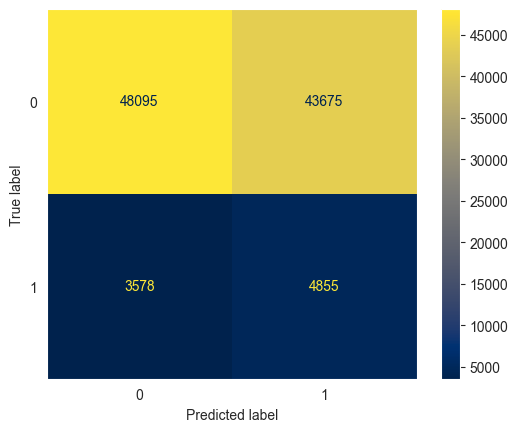

In [73]:
sns.set_style("dark")
plt.figure(figsize=(10, 8), dpi=400)

ConfusionMatrixDisplay.from_estimator(
    grid_search_XGB, X_test, y_test, cmap='cividis'
)

plt.show()

We decided to plot a ROC curve (Receiver Operating Characteristic curve) to further evaluate the model’s performance. The ROC curve is a useful tool in binary classification for assessing how well a model distinguishes between the two classes.

In [74]:
y_XGB_scores = grid_search_XGB.predict_proba(X_test)[:, 1]

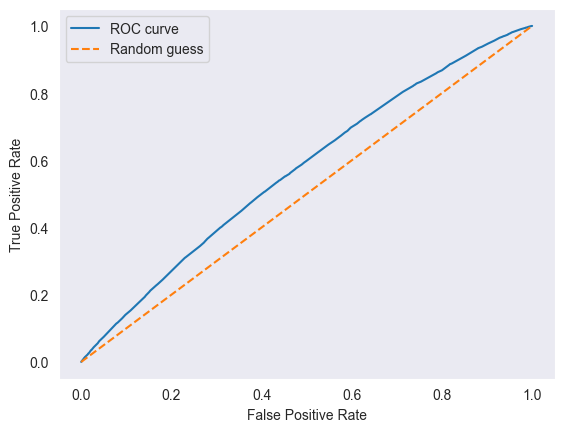

In [75]:
# ROC CURVE
fpr, tpr, thresholds = roc_curve(y_test, y_XGB_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [76]:
print(f"The AUC-ROC score is: {round(roc_auc,10)}")

The AUC-ROC score is: 0.5715093949


The ROC curve and the corresponding AUC indicate poor model performance. As a next step, we decided to plot a Precision-Recall (PR) curve. Even with a balanced dataset, the business impact often prioritizes either recall—catching as many fraud cases as possible—or precision—minimizing false positives and avoiding flagging legitimate users. Therefore, plotting a Precision-Recall curve helps analyze these trade-offs more effectively after training.

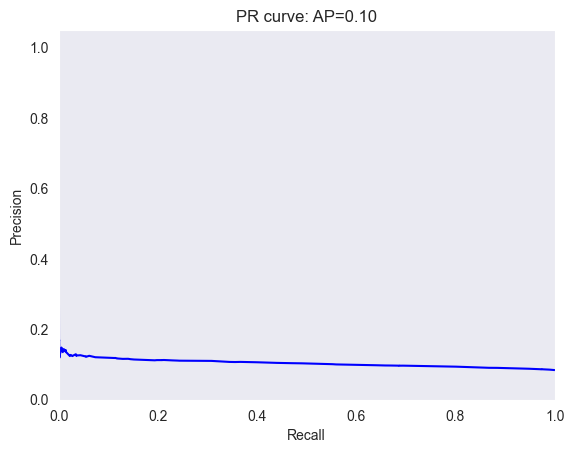

In [77]:
# PR CURVE
precision, recall, thresholds = precision_recall_curve(y_test, y_XGB_scores)

# calculate average precision score
average_precision = average_precision_score(y_test, y_XGB_scores)

# plot the precision-recall curve
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [78]:
auc_score_PRCURVE = auc(recall, precision)
print(f"The AUC-PR score is: {round(auc_score_PRCURVE, 10)}")

The AUC-PR score is: 0.1041224363


A PR-AUC (Precision-Recall Area Under the Curve) score above is very low, indicating that the model performs only marginally better than random guessing at identifying the positive class. This suggests the model struggles significantly with detecting fraudulent cases.

# Feature importance - XGB

- the only model tested is XGB

## SHAP
SHAP values provide a unified measure of feature importance based on game theory concepts. They show how much each feature contributes to a prediction compared to an average baseline.

In [80]:
best_model = grid_search_XGB.best_estimator_

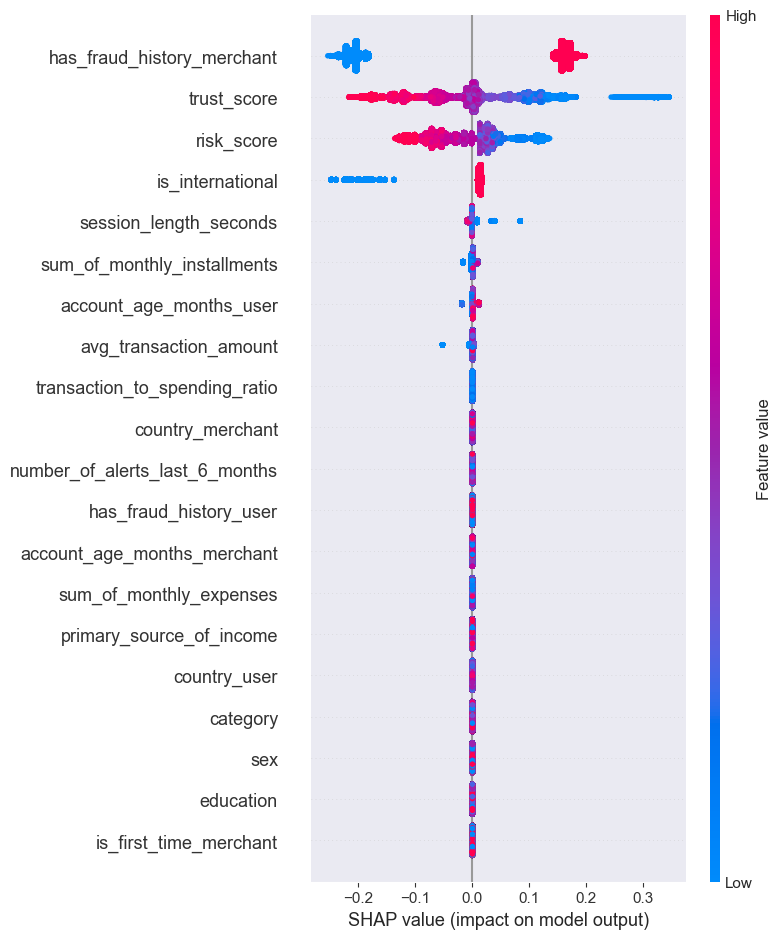

In [81]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [82]:
feature_importance = np.abs(shap_values).mean(axis=0)
feature_importance

array([0.        , 0.        , 0.        , 0.        , 0.02705019,
       0.00337892, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00185537, 0.        , 0.        , 0.0494488 ,
       0.        , 0.        , 0.07337345, 0.        , 0.00106994,
       0.        , 0.18516922, 0.        , 0.00180825, 0.        ],
      dtype=float32)

In [83]:
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"feature_{i}" for i in range(len(feature_importance))]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df = importance_df.reset_index(drop=True)
importance_df

,Feature,Importance
0,has_fraud_history_merchant,0.185169
1,trust_score,0.073373
2,risk_score,0.049449
3,is_international,0.027050
4,session_length_seconds,0.003379
5,sum_of_monthly_installments,0.001855
6,account_age_months_user,0.001808
7,avg_transaction_amount,0.001070
8,amount,0.000000
9,sex,0.000000


### Interpretation

The SHAP feature importance analysis reveals which variables most strongly influence the model’s fraud predictions:

- **has_fraud_history_merchant** is the most influential feature, with a SHAP importance of 0.185. This suggests that a merchant’s prior fraud history is the strongest indicator of future fraudulent transactions.
- **trust_score** and **risk_score** are the next most important features, indicating that both merchant trustworthiness and user risk profiles play some role in fraud detection.
- **is_international** transactions also contribute meaningfully, implying that cross-border transactions are more likely to be flagged as fraudulent.
- **session_length_seconds**, **sum_of_monthly_installments**, **account_age_months_user**, and **avg_transaction_amount** have minor but non-zero importance, suggesting some effects.
- All other features—including transaction amount, user demographics, payment method, device, and categorical variables—have zero importance. This means they do not contribute to the model’s predictive power, possibly due to redundancy, lack of signal, or being overshadowed by more informative features.

## Permutation

Randomly shuffle each feature and see how much the model performance drops and check how much.

In [84]:
result = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

In [85]:
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"feature_{i}" for i in range(X_test.shape[1])]

In [86]:
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
})

In [87]:
perm_importance_df = perm_importance_df.sort_values('Importance', ascending=False)

In [88]:
perm_importance_df = perm_importance_df.reset_index(drop=True)

In [89]:
perm_importance_df

,Feature,Importance,Std
0,has_fraud_history_merchant,0.009979,0.001320
1,is_international,0.000666,0.000560
2,risk_score,0.000255,0.000375
3,account_age_months_user,0.000118,0.000076
4,amount,0.000000,0.000000
5,is_first_time_merchant,0.000000,0.000000
6,channel,0.000000,0.000000
7,device,0.000000,0.000000
8,payment_method,0.000000,0.000000
9,has_fraud_history_user,0.000000,0.000000


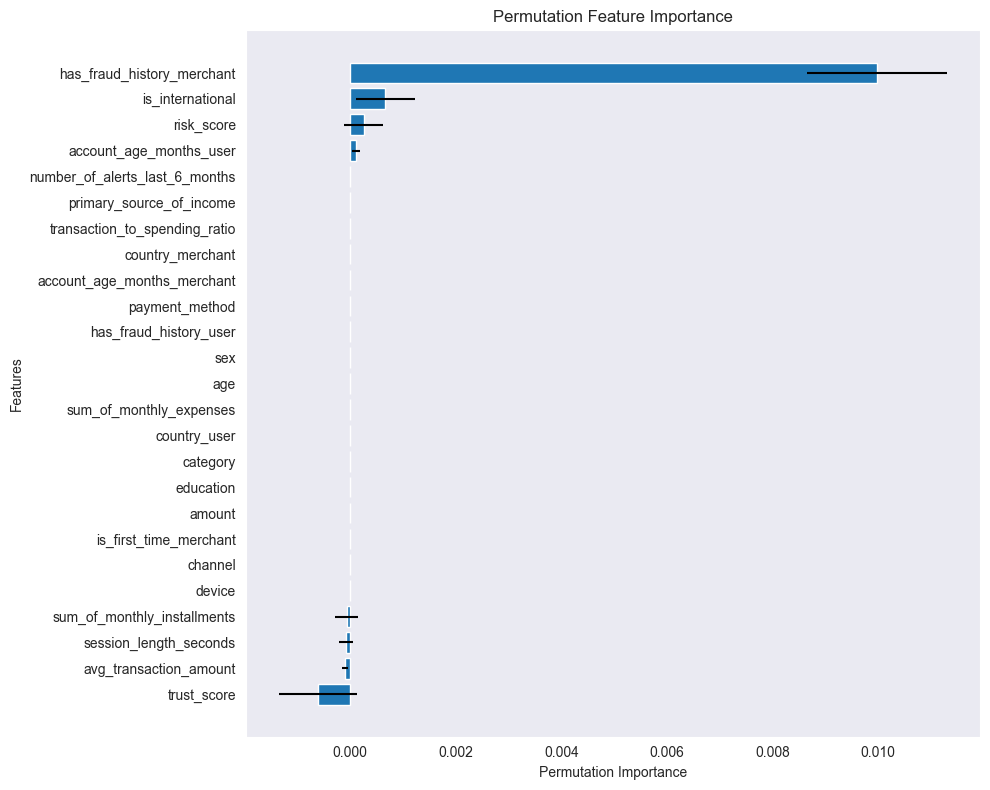

In [90]:
plt.figure(figsize=(10, 8))
sorted_idx = perm_importance_df['Importance'].argsort()
plt.barh(range(len(sorted_idx)), 
         perm_importance_df['Importance'][sorted_idx],
         xerr=perm_importance_df['Std'][sorted_idx],
         align='center')
plt.yticks(range(len(sorted_idx)), perm_importance_df['Feature'][sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

### Interpretaiton

- **has_fraud_history_merchant** - the most important feature. This suggests that a merchant’s prior fraud history is the strongest indicator of future fraudulent transactions.
- **is_international** and **risk_score** - very low importance
- **account_age_months_user** - the lowes importance before 0 values. Suggests that newer accounts may behave differently than established ones.
